In [1]:
import numpy as np
from itertools import chain
from numpy.lib.stride_tricks import as_strided
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

# Convolution using numpy #

In [2]:
def convolution_ver1(image: np.array, kernel: np.array, pad=0, stride=1):
    kernel_h, kernel_w = kernel.shape
    padded_image = np.pad(image, pad)
    padded_image_h, padded_image_w = padded_image.shape
    output = []
    
    for i in range(0, padded_image_h - kernel_h + 1, stride):
        for j in range(0, padded_image_w - kernel_w + 1, stride):
            output.append(np.sum(padded_image[i:i+kernel_w, j:j+kernel_h] * kernel))
            
    output_h, output_w = (padded_image_h - kernel_h) // stride + 1, (padded_image_w - kernel_w) // stride + 1
                       
    return np.array(output).reshape(output_h, output_w)

In [3]:
def convolution_ver2(image: np.array, kernel: np.array, pad=0, stride=1):
    padded_image = np.pad(image, pad)
    padded_image_h, padded_image_w = padded_image.shape
    kernel_h, kernel_w = kernel.shape

    out_shape = ((padded_image_h - kernel_h) // stride + 1, (padded_image_w - kernel_w) // stride + 1, kernel_h, kernel_w)
    out_strides = (padded_image.strides[0] * stride, padded_image.strides[1] * stride, padded_image.strides[0], padded_image.strides[1])
    windows = as_strided(padded_image, shape=out_shape, strides=out_strides)

    return np.tensordot(windows, kernel)

In [4]:
image=np.random.randint(1, 10, size=(7,7))
kernel=np.ones((4,4))
print("Input 'image'\n", image)
print("Kernel\n", kernel)

Input 'image'
 [[6 4 8 6 3 1 7]
 [8 2 6 6 1 8 2]
 [8 7 4 7 9 1 5]
 [9 4 3 5 1 7 3]
 [8 1 5 4 4 1 5]
 [9 6 9 1 1 3 8]
 [5 5 5 1 9 5 7]]
Kernel
 [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]


In [5]:
convolution_ver1(image, kernel, pad=0, stride=3)

array([[93., 72.],
       [80., 65.]])

In [6]:
convolution_ver2(image, kernel, pad=0, stride=3)

array([[93., 72.],
       [80., 65.]])

# Working with an image #

In [7]:
def show_image_tesnor_by_channel(img):
    image = img[0, :, :, :].numpy()
    titles = ['Red channel', 'Green channel', 'Blue channel']
    cmaps = [plt.cm.Reds_r, plt.cm.Greens_r, plt.cm.Blues_r]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 15))
    objs = zip(axes, image.transpose(2, 0, 1), titles, cmaps)

    for ax, channel, title, cmap in objs:
       ax.imshow(channel, cmap=cmap)
       ax.set_title(title)
       ax.set_xticks(())
       ax.set_yticks(())

    plt.show()

def min_max(image):
    data_min = tf.math.reduce_min(image)
    data_max = tf.math.reduce_max(image)
    return (image - data_min)/(data_max - data_min)

## Reading an image ##

(654, 685, 3)


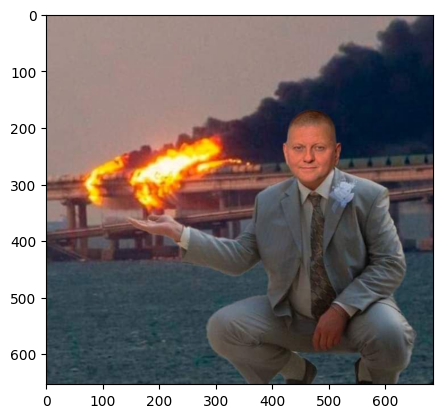

In [8]:
img_brg = cv2.imread('image.jpg', cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_brg, cv2.COLOR_BGR2RGB)
print(img_rgb.shape)
plt.imshow(img_rgb)

## Converting to tensor ##

In [9]:
img_tf = tf.convert_to_tensor(img_rgb, dtype=tf.float32)[tf.newaxis, :, :, :]
img_tf.shape

TensorShape([1, 654, 685, 3])

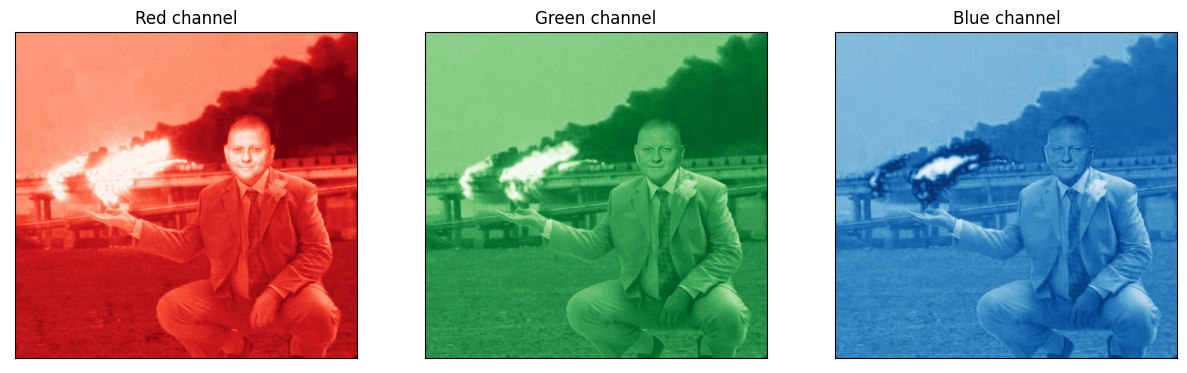

In [10]:
show_image_tesnor_by_channel(img_tf)

## Applying filters ##

### Gaussian filter ###

In [11]:
def gaussian_kernel(size: int, std: float, channels=3):
    dist = tfp.distributions.Normal(0, std)
    values = dist.prob(tf.range(start = -size//2 + 1, limit = size//2 + 1, dtype=tf.float32))
    gauss_kernel = tf.einsum('i,j->ij', values, values)
    gauss_kernel = gauss_kernel / tf.reduce_sum(gauss_kernel)
    
    gauss_kernel = gauss_kernel[:, :, tf.newaxis, tf.newaxis]
    gauss_kernel = tf.tile(gauss_kernel, [1, 1, channels, 1])

    return gauss_kernel

In [12]:
gauss_kernel = gaussian_kernel(25, 4)
gauss_img = tf.nn.depthwise_conv2d(img_tf, gauss_kernel, strides=[1, 1, 1, 1], padding="SAME")

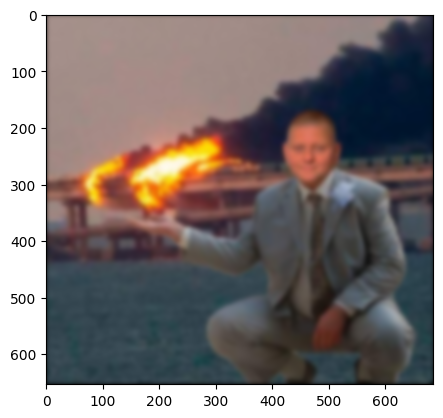

In [13]:
plt.imshow(min_max(gauss_img[0,:,:,:]))

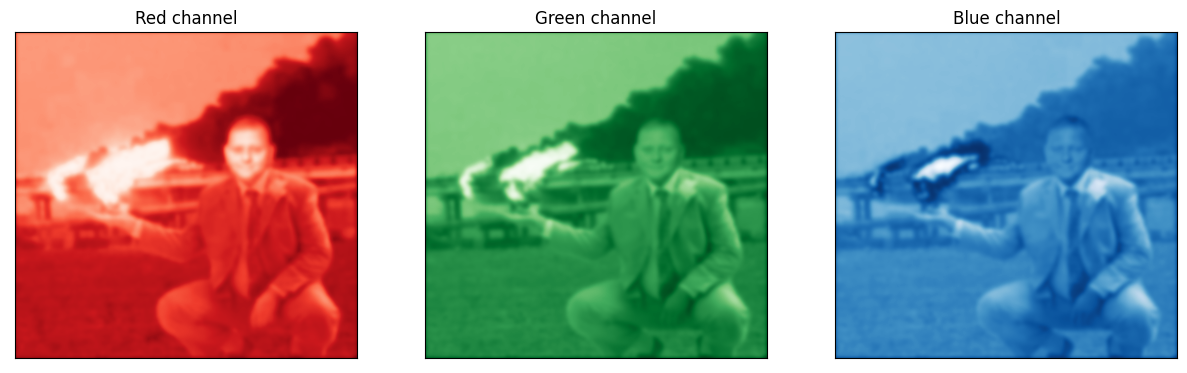

In [14]:
show_image_tesnor_by_channel(gauss_img)

### Box filter ###

In [15]:
def box_filter_kernel(size: int, channels=3):
    box_kernel = tf.ones((size, size))/(size**2)
    box_kernel = box_kernel[:, :, tf.newaxis, tf.newaxis]
    box_kernel = tf.tile(box_kernel, [1, 1, channels, 1])
    return box_kernel

In [16]:
box_filt_kernel = box_filter_kernel(10)
box_img = tf.nn.depthwise_conv2d(img_tf, box_filt_kernel, strides=[1, 1, 1, 1], padding="SAME")

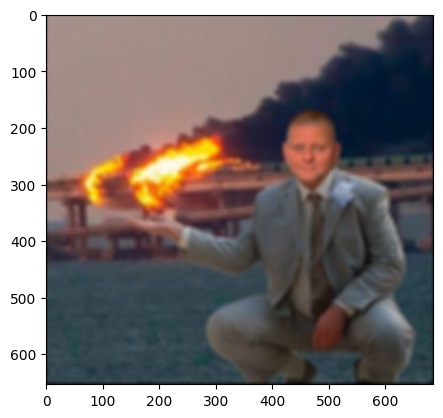

In [17]:
plt.imshow(min_max(box_img)[0,:,:,:])

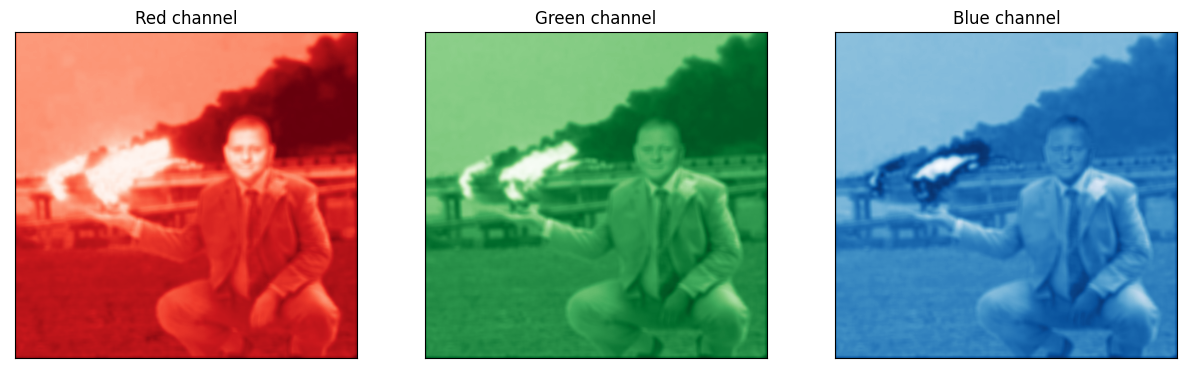

In [18]:
show_image_tesnor_by_channel(box_img)

### Unsharp masking ###

In [19]:
unsharp_img = box_img - 0.7 * gauss_img

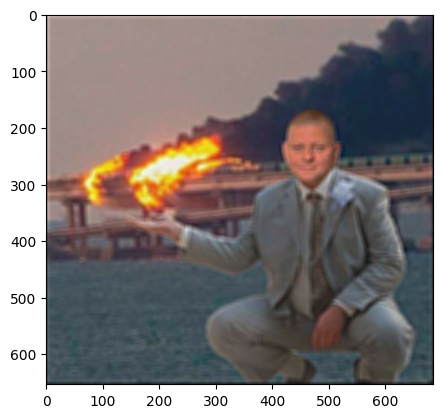

In [20]:
plt.imshow(min_max(unsharp_img)[0,:,:,:])

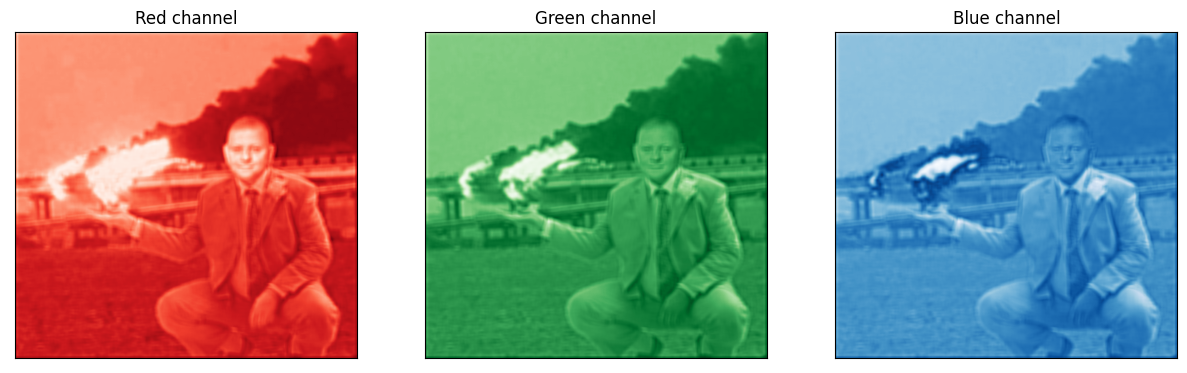

In [21]:
show_image_tesnor_by_channel(unsharp_img)

### Min max ###

In [22]:
min_max_img = min_max(img_tf)

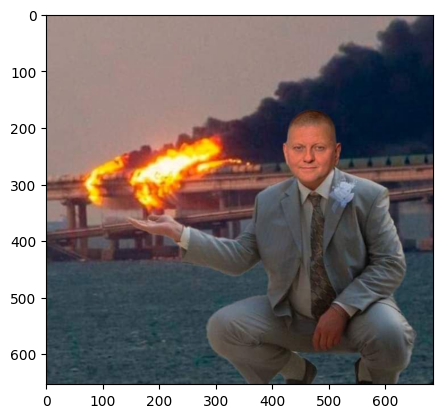

In [23]:
plt.imshow(min_max_img[0,:,:,:])

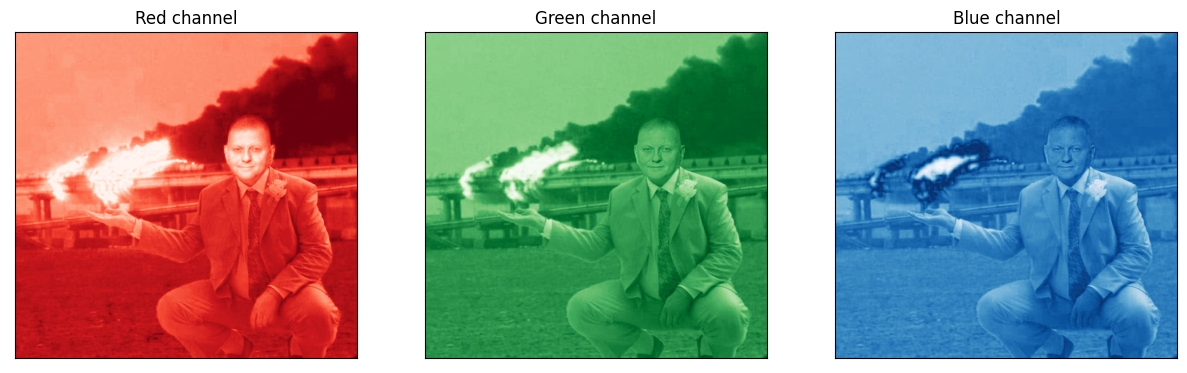

In [24]:
show_image_tesnor_by_channel(min_max_img)

### image standardization ###

In [25]:
stand_img = tf.image.per_image_standardization(img_tf)

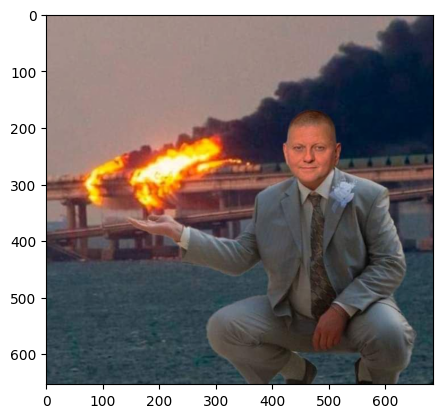

In [26]:
plt.imshow(min_max(stand_img)[0,:,:,:])

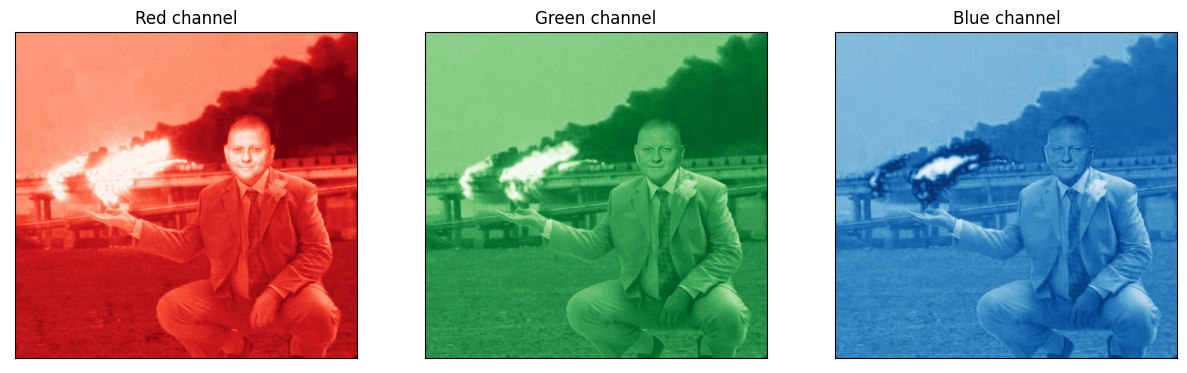

In [27]:
show_image_tesnor_by_channel(stand_img)